<h1>Function section</h1>

In [13]:
from PIL import Image 
import numpy as np 
import numba
import math

# coefficient matrix for inverse laplace
def CoefMtr( n, a = 0 ):
    CoefMtr = np.zeros((n**2,n**2), dtype='float')
    for i in range(n**2):
        CoefMtr[i][i] = 4 + a
        #3 coefficients
            #upper left corner
        if (i == 0):
            CoefMtr[i][i+1] = -1
            CoefMtr[i][i+n] = -1
            #top right corner
        if (i == n - 1):
            CoefMtr[i][i-1] = -1
            CoefMtr[i][i+n] = -1
            #lower left corner
        if (i == (n-1)*n):
            CoefMtr[i][i+1] = -1
            CoefMtr[i][i-n] = -1
            #bottom right corner
        if (i == (n**2 - 1)):
            CoefMtr[i][i-1] = -1
            CoefMtr[i][i-n] = -1
        ###############
            
        #4 coefficients
            #Top side
        if ((i > 0) & (i < n - 1)):
            CoefMtr[i][i-1] = -1
            CoefMtr[i][i+1] = -1
            CoefMtr[i][i+n] = -1
            #Left side
        if ((i % n == 0) & (i != 0) & (i != (n-1)*n)):
            CoefMtr[i][i+1] = -1
            CoefMtr[i][i+n] = -1
            CoefMtr[i][i-n] = -1
            #Right side
        if (((i + 1) % n == 0) & (i != n - 1) & (i != n**2 - 1)):
            CoefMtr[i][i-1] = -1
            CoefMtr[i][i+n] = -1
            CoefMtr[i][i-n] = -1
            #Bottom side
        if ((i > (n - 1)*n) & (i < n**2 - 1)):
            CoefMtr[i][i-1] = -1
            CoefMtr[i][i+1] = -1
            CoefMtr[i][i-n] = -1
        ###############
           
        #5 coefficients
        if ((i > n) & (i < ((n-1)*n - 1)) & (i % n != 0) & ((i + 1) % n != 0)):
            CoefMtr[i][i+1] = -1
            CoefMtr[i][i-1] = -1
            CoefMtr[i][i+n] = -1
            CoefMtr[i][i-n] = -1
        ################
        
    return CoefMtr

# assignment of a circulant matrix
def circulant(b):
    n=len(b)
    a=np.zeros((n,n),dtype=np.float32)
    for i in range(n):
        for j in range(n):
            a[i,j]=b[(j-i)%n]
    return a

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.array( img, dtype=np.uint8 )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )
    
# packing image values in a range of 0 255
def Packing(d): 
    dr=(d-np.min(d))*(255/(np.max(d)-np.min(d)))
    return dr

# orthogonal complement
def Ort(Img, order = 1):
    GI = Garm(Img, order)
    Ort = Img - Packing(GI)
    return Ort

# inverse laplace operator
def InvLap_v3(Img, a = 0):
    n = len(Img)
    Mtr = New_CoefMtr(n, a)
    VecImg = []
    for i in range(n):
        for j in range(n):
            VecImg.append(Img[i][j])
    VecOriginImg = np.linalg.solve(Mtr, VecImg)
    OriginImg = np.zeros((n,n), dtype='float')
    k = 0
    for i in range(n):
        for j in range(n):
            OriginImg[i][j] = VecOriginImg[k]
            k = k + 1
    return OriginImg

# window method of the laplace operator
def Win_Lap_dop(data,k,p):
    n=len(data)
    im=np.zeros((n,n),dtype=np.float32)
    res=np.zeros((n,n),dtype=np.float32)
    for i in range(n):
        for j in range(n):
            im[i,j]=data[i,j]
    m=n*n
    nk=n//k
    b=np.zeros((k,k),dtype=np.float32)
    
    for p in range(nk+nk-1):
        for q in range(nk+nk-1):
            kp=k*p
            kq=k*q
            kp2=kp//2
            kq2=kq//2
            for i in range(k):
                for j in range(k):
                    b[i,j]=im[i+kp2,j+kq2]
            temp=(Laplas(1,b,p))
            for i in range(k//4,k-k//4):
                for j in range(k//4,k-k//4):
                    if np.isnan(temp[i,j]):
                        print("NaN")
                        return b
                    res[i+kp2,j+kq2]=temp[i,j]
    return res

#ABSOLUTELY ULTIMATIVE TESTING FUNCTION
def AUTF(*list_func, img):
    dict_func = {
        1: Packing,
        2: Unpacking,
        3: Laplas,
        4: inverseLap,
        5: QuasiInvLap,
        6: PoliLaplas,
#         7: My_SVD,
        8: CoefMtr,
        9: InvLap_v3
    }
    for i in range(len(list_func)):
        if type(list_func[i]) == list:
            cur_func = dict_func.get(list_func[i][0])
            arg_func = list_func[i][1]
            NewImg = cur_func(img, arg_func)
            img = NewImg
        else:
            cur_func = dict_func.get(list_func[i])
            NewImg = cur_func(img)
            img = NewImg
    return NewImg

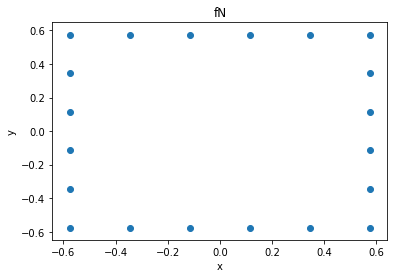

In [15]:
# Parameters for setting points
m = 5
ld=0.075
x0=0.5+ld
h=2*x0/m
ln=np.log
###
# Defining an array of points
#xp=[0]*20
#yp=[0]*20
xp=[0]*4*m
yp=[0]*4*m
for i in range(0,4*m):
    xp[i]=((i//(2*m)+1)%2)*(-x0+h*(i-m)*(i//m))+(i//(2*m))*(x0-h*(i-3*m)*(i//(3*m)))
for i in range(0,4*m):
    yp[i]=xp[(i+m)%(4*m)]
###
# Drawing a graph
import matplotlib.pyplot as plt
x = xp
y = yp
plt.scatter(x, y)
plt.title('fN')
plt.ylabel('y')
plt.xlabel('x')
plt.show()
###

import numba
@numba.jit
# Fundamental decision
def FunSolve(x,y,k,m):
    return ln(((xp[k]-x)**2+(yp[k]-y)**2))*(((xp[k]-x)**2+(yp[k]-y)**2)**(m + m-2))
###

def Garm(Img, gar = 1):
    n = len(Img)
    import numpy as np
    A = np.zeros((4*m,4*m,))
    B = np.zeros((4*m))
    from scipy.integrate import dblquad
    #A
    for i in range(4*m):
        for j in range(4*m):
            A[i,j]=dblquad(lambda x, y: FunSolve(x,y,i,gar)*FunSolve(x,y,j,gar), -0.5, 0.5, lambda x: -0.5, lambda x: 0.5)[0]
    ###
    #B
    for k in range(4*m):
        for i in range(n):
            for j in range(n):
                B[k]=B[k]+(Img[i][j])*FunSolve(-0.5+j/(n-1),0.5-i/(n-1),k,gar)/(n*n)
    ###
    #C
    C=np.linalg.solve(A,B)
    ###
    # Isolation of the harmonic component
    G=np.zeros((n,n),dtype=np.float32)
    for i in range(n):
            for j in range(n):
                for k in range(4*m):
                    G[i][j]=G[i][j]+C[k]*FunSolve(-0.5+j/(n-1),0.5-i/(n-1),k,gar)
    ###
    return G


In [5]:
# laplace operator
@numba.jit
def Laplas(k,smooth_r,p=1):
    n1=len(smooth_r)
    lpls=np.zeros((n1,n1),dtype=np.float32)
    exp=np.zeros((n1+k+k,n1+k+k),dtype=np.float32)
    for i in range(k,n1+k):
        for j in range(k,n1+k):
            exp[i,j]=smooth_r[i-k,j-k]
    
    for i in range(n1):
        for j in range(n1):
            lpls[i][j]=-np.abs(Laplas_P(i+k,j+k,k,exp,p))
    return lpls

In [6]:
@numba.jit
def Laplas_P(i,j,n,data, p):
    if n==0:
        return data[i,j]
    else:
        return Laplas_P(i,j-1,n-1,data,p)+Laplas_P(i,j+1,n-1,data,p)+Laplas_P(i-1,j,n-1,data,p)+Laplas_P(i+1,j,n-1,data,p)-(4-p)*Laplas_P(i,j,n-1,data,p)

In [7]:
# higher degree laplace operator
@numba.jit
def PoliLaplas(smooth_r, k):
    n1=len(smooth_r)
    lpls=np.zeros((n1+k,n1+k),dtype=np.float32)
    exp=np.zeros((n1+k,n1+k),dtype=np.float32)
    for i in range(k,n1+k):
        for j in range(k,n1+k):
            exp[i,j]=smooth_r[i-k,j-k]

    for i in range(n1):
        for j in range(n1):
            lpls[i][j]=-np.abs(Laplas_P(i,j,k,exp))
    return lpls

In [11]:
@numba.jit
def Laplas_v2(k,smooth_r,p=0):
    n1=len(smooth_r)
    lpls=np.zeros((n1,n1),dtype=np.float32)
    exp=np.zeros((n1+k+k,n1+k+k),dtype=np.float32)
    for i in range(k,n1+k):
        for j in range(k,n1+k):
            exp[i,j]=smooth_r[i-k,j-k]

    for i in range(n1):
        for j in range(n1):
            lpls[i][j]=-np.abs(Laplas_P(i+k,j+k,k,exp,p))
    return lpls

<h1>Computational experiments</h1>

In [12]:
import random
for num in range(6, 13):
    bd1 = load_image("/Users/danii/Desktop/Scientific activity/EKB/source/bd"+str(num)+".bmp")
    for i in np.arange(0.4, 3, 0.2):
        x1 = round(random.uniform(-0.3, 0.3), 2)
        x2 = round(random.uniform(-0.3, 0.3), 2)
        x3 = round(random.uniform(-0.3, 0.3), 2)
        L1 = Laplas_v2(2, bd1, i + x1)
        L2 = Laplas_v2(1, L1, i + x2)
        L3 = Laplas_v2(3, L2, i + x3)
        save_image(Packing(L3), "/Users/danii/Desktop/Scientific activity/EKB/task1_2/Композиция_3/Разные_параметры/L2_L1_L3/"+str(num)+"/bd"+str(num)+"_L1("+str(round(i + x1,2))+")_L2("+str(round(i + x2,2))+")_L3("+str(round(i + x3,2))+").bmp")

NameError: name 'Laplas_v2' is not defined

In [ ]:
for num in range(6, 13):
    bd1 = load_image("/Users/danii/Desktop/Scientific activity/EKB/source/bd"+str(num)+".bmp")
    for i in np.arange(0.4, 3, 0.2):
        L1 = Laplas_v2(2, bd1, i)
        L2 = Laplas_v2(1, L1, i)
        L3 = Laplas_v2(3, L2, i)
        save_image(Packing(L3), "/Users/danii/Desktop/Scientific activity/EKB/task1_2/Композиция_3/Одинаковые_параметры/L2_L1_L3/"+str(num)+"/bd"+str(num)+"_"+str(round(i,1))+".bmp")

In [ ]:
img = load_image("/Users/danii/Desktop/Scientific activity/EKB/source/bd8_300.bmp")
img2 = load_image("/Users/danii/Desktop/Scientific activity/EKB/source/bd9_300.bmp")

for num in range(1, 7):
    garm = load_image("/Users/danii/Desktop/Scientific activity/EKB/11/out"+str(num)+".bmp")
    for i in range(len(img)):
        for j in range(len(img)):
            if img[i][j] != img2[i][j]:
                img2[i][j] = garm[i][j]
    save_image(img2, "/Users/danii/Desktop/Scientific activity/EKB/final_task/task/with_garm"+str(num)+".bmp")


In [ ]:
Img = load_image("/Users/danii/Desktop/Scientific activity/Laplas/Window_Lap/BorderOfBorder/(360)test_Window(15)_InvLap_v3.png")
Img2axis = np.zeros((len(Img),len(Img)), dtype = np.float32)
for i in range(len(Img)):
    for j in range(len(Img)):
        Img2axis[i][j] = Img[i][j]
NewImg = Laplas(Img2axis)
#NewImg = InvLap_v3(Img2axis, 0.1)
save_image(Packing(NewImg), "/Users/danii/Desktop/Scientific activity/Laplas/Window_Lap/BorderOfBorder/Lap/Lap_InvLap_v3.png")

In [ ]:
import time
Img = load_image("/Users/danii/Desktop/Scientific activity/Garm/PoliLap/TestWithEnemyPhoto/ErrMan.png")
Img2axis = np.zeros((len(Img),len(Img)), dtype = np.float32)
for i in range(len(Img)):
    for j in range(len(Img)):
        Img2axis[i][j] = Img[i][j][1]
start_recur = time.time()
QILImg = QuasiInvLap(Img2axis, 50000)
end_recur = time.time()
#LapImg = PoliLaplas(Img2axis, 1)
#QIL_Lap = QuasiInvLap(LapImg, 300)
Lap_QIL = PoliLaplas(QILImg, 1)
#Lap_QIL_Lap = PoliLaplas(QIL_Lap, 5)
Img2axis = Packing(Lap_QIL)
#for i in range(len(Img)):
#    for j in range(len(Img)):
#        if (Img2axis[i][j] >=130) and (Img2axis[i][j] < 255):
#            Img2axis[i][j] = 137
save_image(Img2axis, "/Users/danii/Desktop/Scientific activity/Garm/PoliLap/TestWithEnemyPhoto/ErrMan_QIL(1000).png")
print(end_recur-start_recur)